In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [3]:
def plotCSNS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [5]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_ros3','backadm_ros3','backvs_ros3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2019,12,12)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                print(date)
                pass


In [52]:
transp_2018['for']

{'forpr_ros3': [27966.861351203173,
  27482.744500152774,
  25814.798513150177,
  24966.68504267331,
  31256.60740680599,
  27878.62820565237,
  39412.79816699911,
  34020.78883113328,
  35417.597570283266,
  31836.512789145574,
  43857.80395878324,
  36937.267236133164,
  30587.891919627546,
  23996.765512872495,
  25457.20343344241,
  28176.965261044326,
  31042.324990488734,
  33124.79071857156,
  33709.5301196043,
  25077.82990958284,
  24787.430871930275,
  31413.11103381747,
  34377.69888035442,
  39107.82412172119,
  38558.475783954505,
  38546.02115472351,
  34275.70385577208,
  31582.379584283008,
  21920.074291558376,
  22498.25151307027,
  22336.683588285538,
  21572.26382868956,
  17989.677437364662,
  18028.535659638917,
  18423.5794317494,
  21542.586957544896,
  20723.538456841576,
  18110.445256925886,
  18089.02246627795,
  21442.415566556287,
  23602.549590825263,
  26578.677720074724,
  30361.019852320147,
  28245.330082554618,
  27896.115612032172,
  22756.555337302

In [6]:
dict_secdata = {}

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            dict_secdata[file][section] = get_secdata(dicts[file][date],section)

In [7]:
dict_secdata['forpr_ros3'][0]['final_salt']

<xarray.DataArray 'final_salt' (ntraj: 14148)>
[14148 values with dtype=float32]
Dimensions without coordinates: ntraj
Attributes:
    title:     What is final_salt ?
    longname:  Final salinity
    units:     psu

In [8]:
month_avg = np.zeros([12,len(sectransp_2018['forpr_ros3'].keys())])

for sectionnum in sectransp_2018['forpr_ros3'].keys():
    intermed = sectransp_2018['forpr_ros3'][sectionnum]
    for month in range(1,13):
        dates = [index for index, date in enumerate(datelist_vs) if date.month == month]
        selected_elements = [sectransp_2018['forpr_ros3'][sectionnum][index] for index in dates]
        month_avg[month-1,sectionnum] = np.mean(selected_elements)
    

In [9]:
dates = [index for index, date in enumerate(datelist_vs) if date.month == 1]
selected_elements = [sectransp_2018['forpr_ros3'][0][index] for index in dates]
date_jan = [datelist_vs for index in dates]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2019,1,1)

dates = []
datelist_yr = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yr.append(date)
    date+=dt.timedelta(days=31)

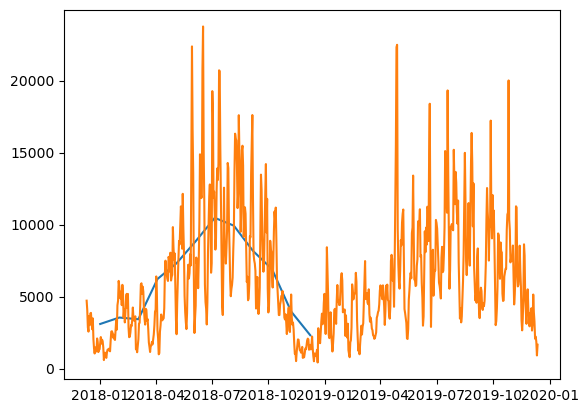

In [10]:
plt.plot(datelist_yr,month_avg[:,4])
plt.plot(datelist_vs,sectransp_2018['forpr_ros3'][4])

### Shifting functions

In [11]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

### Import density data

In [12]:
# Importing density and tidal data

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2018_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

density_rosVS = pd.read_csv('sigma_2018_rosariopr_202111_meanv2.csv')
dens_diff_rosVS = np.array(density_rosVS.south - density_rosVS.north)

density_haro = pd.read_csv('sigma_2018_harovs_202111_mean_v2.csv')
dens_diff_haro = np.array(density_haro.south - density_haro.north)

tides = pd.read_csv('low_pass_tide_18-22.csv')

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2019,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
dens_diff_ros

2191
(2191,)


array([24.29067796, 24.300836  , 24.17309402, ..., 23.78621478,
       23.7777716 , 23.71792241])

In [13]:
wind = pd.read_csv('../notebooks/day_avg_wind.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2019,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

#### Rosario to adm

In [14]:
PRtoadm_rosl = sectransp_2018['forpr_ros3'][2]
PRtoadm_rosbl = sectransp_2018['backadm_ros3'][4]

PRtoadm_ros = pd.Series(PRtoadm_rosl,index=datelist_vs)
PRtoadm_rosb = pd.Series(PRtoadm_rosbl,index=datelist_vs)

In [15]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base,factor)
        dfr2 = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.595:
            print (base, factor, corr_arr[i, j])

-1.0 0.40000000000000124 0.5958859227011436
-0.95 0.40000000000000124 0.5954794641136852
-0.8999999999999999 0.40000000000000124 0.5965936731984268
-0.8499999999999999 0.40000000000000124 0.5950468656477522
-0.7999999999999998 0.40000000000000124 0.5994200180978374
0.3500000000000012 0.3500000000000012 0.5953662866852063


In [16]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.8] [0.4]


0.5994200180978374


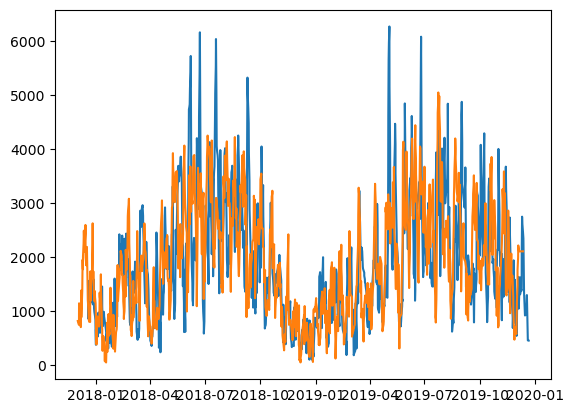

In [17]:
PRtoadm_ros_sh = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base_adm[0],factor_adm[0])
PRtoadm_rosb_sh = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtoadm_ros_m,PRtoadm_rosb_m,c,PRtoadm_ros_avg = merge(PRtoadm_ros_sh,PRtoadm_rosb_sh)
print(c)

plt.plot(PRtoadm_ros_m.Transport)
plt.plot(PRtoadm_rosb_m.Transport)

#### Now do this same for only 2018

In [59]:
PRtoadm2018_rosl = sectransp_2018['forpr_ros3'][2][0:385]
PRtoadm2018_rosbl = sectransp_2018['backadm_ros3'][4][0:385]

PRtoadm2018_ros = pd.Series(PRtoadm2018_rosl,index=datelist_vs[0:385])
PRtoadm2018_rosb = pd.Series(PRtoadm2018_rosbl,index=datelist_vs[0:385])

In [61]:
PRtoadm2018_rosb

2017-12-10     820.595292
2017-12-11    1149.001901
2017-12-12     749.904988
2017-12-13     707.988881
2017-12-14     889.198318
                 ...     
2018-12-25     511.828848
2018-12-26     455.538490
2018-12-27     789.910587
2018-12-28     606.814459
2018-12-29     413.102430
Length: 385, dtype: float64

In [63]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2018_ros,age_2018['forpr_ros3'][2][0:385],datelist_vs[0:385],base,factor)
        dfr2 = shift_time(PRtoadm2018_rosb,age_2018['backadm_ros3'][4][0:385],datelist_vs[0:385],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])

-0.8499999999999999 0.15000000000000102 0.6520339623467446
-0.7999999999999998 0.15000000000000102 0.6550074656313384
-0.7499999999999998 0.15000000000000102 0.6539740414298298


In [65]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.8] [0.15]


0.6550074656313384


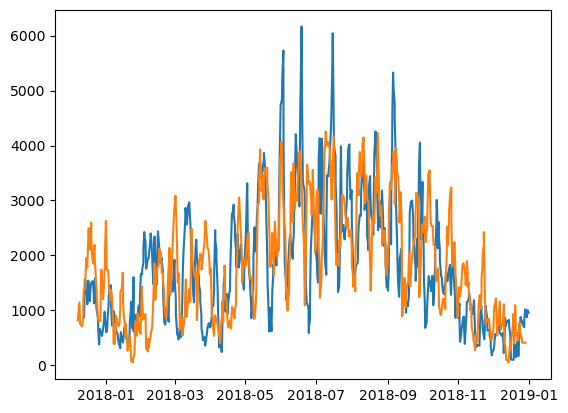

In [67]:
PRtoadm2018_ros_sh = shift_time(PRtoadm2018_ros,age_2018['forpr_ros3'][2][0:385],datelist_vs[0:385],base_adm[0],factor_adm[0])
PRtoadm2018_rosb_sh = shift_time(PRtoadm2018_rosb,age_2018['backadm_ros3'][4][0:385],datelist_vs[0:385],-base_adm[0],-factor_adm[0])

PRtoadm2018_ros_m,PRtoadm2018_rosb_m,c,PRtoadm2018_ros_avg = merge(PRtoadm2018_ros_sh,PRtoadm2018_rosb_sh)
print(c)

plt.plot(PRtoadm2018_ros_m.Transport)
plt.plot(PRtoadm2018_rosb_m.Transport)

#### Now do this for only 2019

In [22]:
PRtoadm2019_rosl = sectransp_2018['forpr_ros3'][2][387:]
PRtoadm2019_rosbl = sectransp_2018['backadm_ros3'][4][387:]

PRtoadm2019_ros = pd.Series(PRtoadm2019_rosl,index=datelist_vs[387:])
PRtoadm2019_rosb = pd.Series(PRtoadm2019_rosbl,index=datelist_vs[387:])

In [23]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2019_ros,age_2018['forpr_ros3'][2][387:],datelist_vs[387:],base,factor)
        dfr2 = shift_time(PRtoadm2019_rosb,age_2018['backadm_ros3'][4][387:],datelist_vs[387:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])

0.30000000000000115 0.30000000000000115 0.5718176986852819
0.5000000000000013 0.30000000000000115 0.5741787454571446
0.5500000000000014 0.30000000000000115 0.5749391146175942
0.6000000000000014 0.30000000000000115 0.5730840504354243
0.6500000000000015 0.30000000000000115 0.5706197262219523
0.8500000000000016 0.30000000000000115 0.5716377775343604
0.9000000000000017 0.30000000000000115 0.5732429925090483


In [24]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[0.55] [0.3]


0.5749391146175942


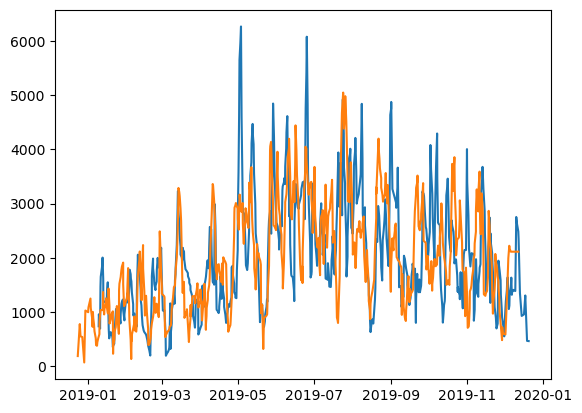

In [25]:
PRtoadm2019_ros_sh = shift_time(PRtoadm2019_ros,age_2018['forpr_ros3'][2][387:],datelist_vs[387:],base_adm[0],factor_adm[0])
PRtoadm2019_rosb_sh = shift_time(PRtoadm2019_rosb,age_2018['backadm_ros3'][4][387:],datelist_vs[387:],-base_adm[0],-factor_adm[0])

PRtoadm2019_ros_m,PRtoadm2019_rosb_m,c,PRtoadm2019_ros_avg = merge(PRtoadm2019_ros_sh,PRtoadm2019_rosb_sh)
print(c)

plt.plot(PRtoadm2019_ros_m.Transport)
plt.plot(PRtoadm2019_rosb_m.Transport)

### PR to VicSill

In [26]:
PRtovs_rosl = sectransp_2018['forpr_ros3'][4]
PRtovs_rosbl = sectransp_2018['backvs_ros3'][4]

PRtovs_ros = pd.Series(PRtovs_rosl,index=datelist_vs)
PRtovs_rosb = pd.Series(PRtovs_rosbl,index=datelist_vs)

In [27]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.68:
            print (base, factor, corr_arr[i, j])

-1.0 0.30000000000000115 0.684541957240086


In [28]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-1.] [0.3]


0.684541957240086


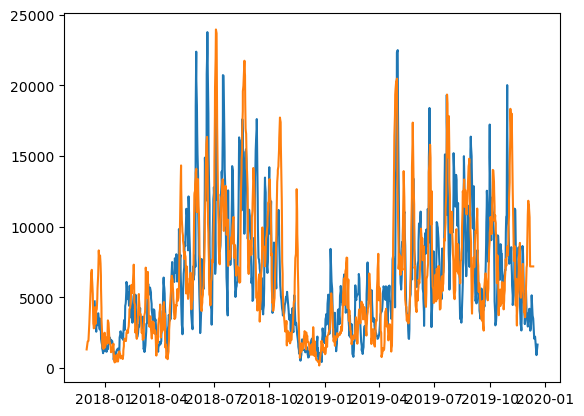

In [29]:
PRtovs_ros_sh = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base_adm[0],factor_adm[0])
PRtovs_rosb_sh = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtovs_ros_m,PRtovs_rosb_m,c,PRtovs_ros_avg = merge(PRtovs_ros_sh,PRtovs_rosb_sh)
print(c)

plt.plot(PRtovs_ros_m.Transport)
plt.plot(PRtovs_rosb_m.Transport)

#### Now do this for only 2018

In [68]:
PRtovs2018_rosl = sectransp_2018['forpr_ros3'][4][0:385]
PRtovs2018_rosbl = sectransp_2018['backvs_ros3'][4][0:385]

PRtovs2018_ros = pd.Series(PRtovs2018_rosl,index=datelist_vs[0:385])
PRtovs2018_rosb = pd.Series(PRtovs2018_rosbl,index=datelist_vs[0:385])

In [72]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2018_ros,age_2018['forpr_ros3'][4][0:385],datelist_vs[0:385],base,factor)
        dfr2 = shift_time(PRtovs2018_rosb,age_2018['backvs_ros3'][4][0:385],datelist_vs[0:385],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.73:
            print (base, factor, corr_arr[i, j])

-1.0 0.30000000000000115 0.7383132790320881
-0.7499999999999998 0.2500000000000011 0.7303184671278201
-0.6499999999999997 0.2500000000000011 0.7314656453815972
-0.5999999999999996 0.2500000000000011 0.7307758320789479
-0.39999999999999947 0.2500000000000011 0.730445030017987
-0.3499999999999994 0.2500000000000011 0.7342245171321492
0.15000000000000102 0.20000000000000107 0.7317687809152374
0.20000000000000107 0.20000000000000107 0.7339911066854953


In [74]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-1.] [0.3]


0.7383132790320881


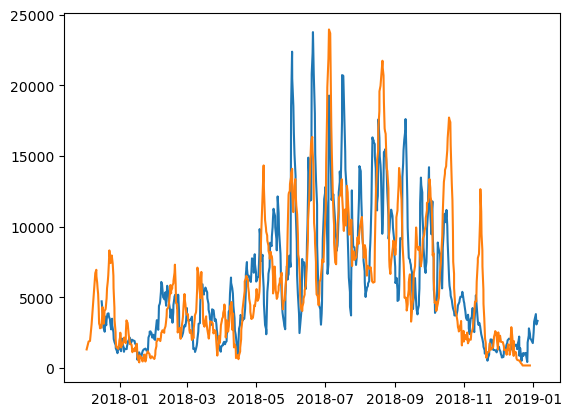

In [75]:
PRtovs2018_ros_sh = shift_time(PRtovs2018_ros,age_2018['forpr_ros3'][4][0:385],datelist_vs[0:385],base_adm[0],factor_adm[0])
PRtovs2018_rosb_sh = shift_time(PRtovs2018_rosb,age_2018['backvs_ros3'][4][0:385],datelist_vs[0:385],-base_adm[0],-factor_adm[0])

PRtovs2018_ros_m,PRtovs2018_rosb_m,c,PRtovs2018_ros_avg = merge(PRtovs2018_ros_sh,PRtovs2018_rosb_sh)
print(c)

plt.plot(PRtovs2018_ros_m.Transport)
plt.plot(PRtovs2018_rosb_m.Transport)

#### Now do this for 2019

In [34]:
PRtovs2019_rosl = sectransp_2018['forpr_ros3'][4][387:]
PRtovs2019_rosbl = sectransp_2018['backvs_ros3'][4][387:]

PRtovs2019_ros = pd.Series(PRtovs2019_rosl,index=datelist_vs[387:])
PRtovs2019_rosb = pd.Series(PRtovs2019_rosbl,index=datelist_vs[387:])

In [35]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2019_ros,age_2018['forpr_ros3'][4][387:],datelist_vs[387:],base,factor)
        dfr2 = shift_time(PRtovs2019_rosb,age_2018['backvs_ros3'][4][387:],datelist_vs[387:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])

-1.0 0.30000000000000115 0.5823745348800554
-0.49999999999999956 0.2500000000000011 0.5745365513417198
-0.4499999999999995 0.2500000000000011 0.5731368647186172
0.2500000000000011 0.20000000000000107 0.5721298373469844


In [36]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-1.] [0.3]


0.5823745348800554


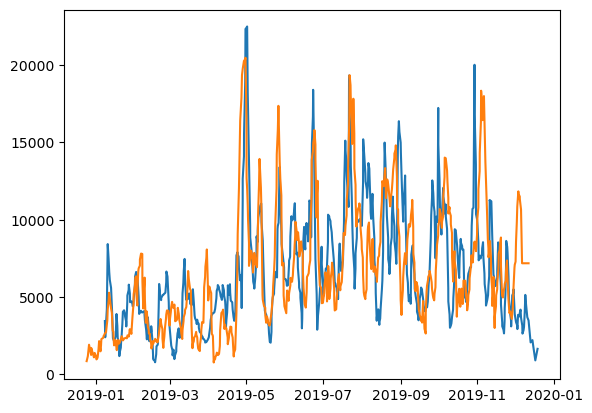

In [37]:
PRtovs2019_ros_sh = shift_time(PRtovs2019_ros,age_2018['forpr_ros3'][4][387:],datelist_vs[387:],base_adm[0],factor_adm[0])
PRtovs2019_rosb_sh = shift_time(PRtovs2019_rosb,age_2018['backvs_ros3'][4][387:],datelist_vs[387:],-base_adm[0],-factor_adm[0])

PRtovs2019_ros_m,PRtovs2019_rosb_m,c,PRtovs2019_ros_avg = merge(PRtovs2019_ros_sh,PRtovs2019_rosb_sh)
print(c)

plt.plot(PRtovs2019_ros_m.Transport)
plt.plot(PRtovs2019_rosb_m.Transport)

In [78]:
rostosouth_2018 = PRtovs2018_ros_avg + PRtoadm2018_ros_avg

date2018_rossh = list(rostosouth_2018.dropna().index)

mask = np.isin(datelist_dens,date2018_rossh)
densdiff_ros2018 = dens_diff_ros[mask]
densdiff_ros2 = dens_diff_rosVS[mask]
date_dens_2018sh = np.array(datelist_dens)[mask]

corr_rostosouth2018,p = stats.spearmanr(densdiff_ros2018,rostosouth_2018.dropna())
print('2018:',corr_rostosouth2018)

# mask = np.isin(datelist_tides,date2018_rossh)
# tides2018_sh = tides.vozocrtx[mask]

rostosouth_2019 = PRtovs2019_ros_avg.dropna() + PRtoadm2019_ros_avg.dropna()

date2019_rossh = list(rostosouth_2019.dropna().index)

mask = np.isin(datelist_dens,date2019_rossh)
densdiff_ros2019 = dens_diff_ros[mask]
densdiff_ros2 = dens_diff_rosVS[mask]
date_dens_2019sh = np.array(datelist_dens)[mask]

corr_rostosouth2019,p = stats.spearmanr(densdiff_ros2019,rostosouth_2019.dropna())
print('2019:',corr_rostosouth2019)


2018: 0.8292558573214036
2019: 0.6793411735491168


In [79]:
rostosouth_2018.dropna()

2017-12-16    5717.056867
2017-12-17    5410.744930
2017-12-18    4982.965563
2017-12-19    5634.886245
2017-12-20    5908.381155
                 ...     
2018-12-25    1305.061622
2018-12-26    1100.395288
2018-12-27    1563.614370
2018-12-28    1874.142372
2018-12-29    1986.504325
Name: Transport, Length: 379, dtype: float64

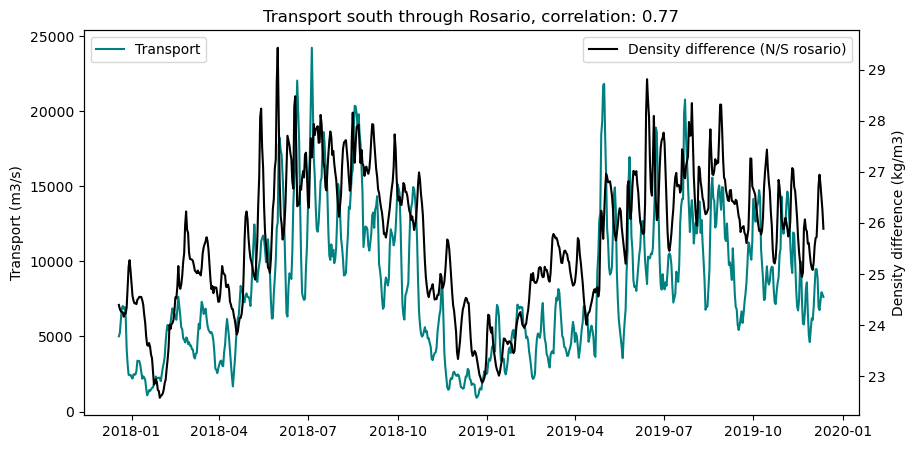

In [40]:
rostosouth = PRtovs_ros_avg + PRtoadm_ros_avg
date_rossh = list(rostosouth.dropna().index)

mask = np.isin(datelist_dens,date_rossh)
densdiff_ros = dens_diff_ros[mask]
densdiff_ros2 = dens_diff_rosVS[mask]
date_dens_sh = np.array(datelist_dens)[mask]

corr_rostosouth,p = stats.spearmanr(densdiff_ros,rostosouth.dropna())

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_sh,densdiff_ros,color='k',label='Density difference (N/S rosario)')
ax.set_title(f'Transport south through Rosario, correlation: {np.round(corr_rostosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

Text(0.5, 1.0, 'corr = -0.08')

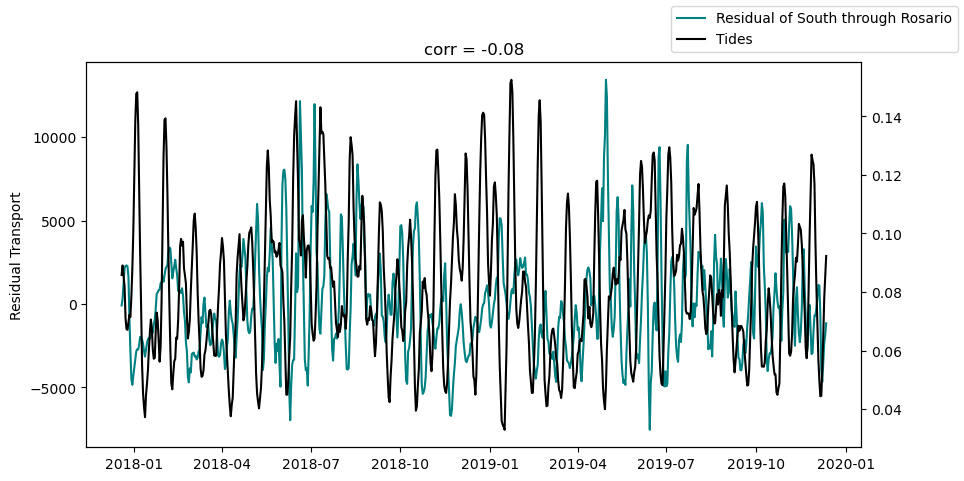

In [41]:
slope,intercept = np.polyfit(densdiff_ros,rostosouth.dropna(),1)
ddline = slope*densdiff_ros+intercept
res = rostosouth.dropna() - ddline

slope,intercept = np.polyfit(densdiff_ros2,rostosouth.dropna(),1)
ddline2 = slope*densdiff_ros2+intercept
res_ros2 = rostosouth.dropna() - ddline2

mask = np.isin(datelist_tides,date_rossh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_sh = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_sh,res)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')

Text(0.5, 1.0, 'corr = -0.226')

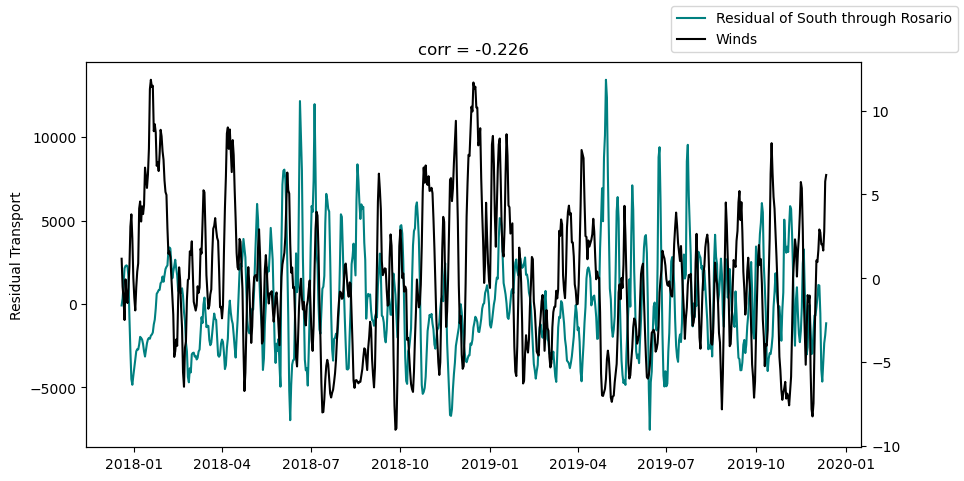

In [42]:
mask = np.isin(datelist_winds,date_rossh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_sh = y_mean4[mask]

corr,p = stats.spearmanr(winds_sh,res)
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_winds_sh,winds_sh,color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')

In [81]:
# Calculate correlations separately
idx = 379
idx_z2 = 110
idx_z3 = 220
idx_z4 = 300

ros2south_2018 = rostosouth_2018.dropna()
ros2south_2019 = rostosouth_2019.dropna()
winds_2018 = winds_sh[0:idx]
winds_2019 = winds_sh[idx:]
mask = np.isin(datelist_dens,date2018_rossh)
densdiff_ros_2018 = dens_diff_ros[mask]
densdiff_ros_2019 = densdiff_ros[idx:]
tides_2018 = tides_sh[0:idx]
tides_2019 = tides_sh[idx:]
res_2018 = res[0:idx]
res_2019 = res[idx:]
date_2018 = date_tides_sh[0:idx]
date_2019 = date_tides_sh[idx:]

#Separate ddline for 2018 and 2019

slope,intercept = np.polyfit(densdiff_ros2018,rostosouth_2018.dropna()[0:379],1)
ddline2018 = slope*densdiff_ros2018+intercept
res2018 = rostosouth_2018.dropna()[0:379] - ddline2018
print(slope,intercept)

mask = np.isin(datelist_tides,date2018_rossh)
date_tides_2018sh = np.array(datelist_tides)[mask]
tides2018_sh = tides.vozocrtx[mask]

slope,intercept = np.polyfit(densdiff_ros2019,rostosouth_2019.dropna(),1)
ddline2019 = slope*densdiff_ros2019+intercept
res2019 = rostosouth_2019.dropna() - ddline2019

mask = np.isin(datelist_tides,date2019_rossh)
date_tides_2019sh = np.array(datelist_tides)[mask]
tides2019_sh = tides.vozocrtx[mask]


2750.351224256408 -62426.847692377734


In [85]:
tides2018_sh

349    0.085420
350    0.084437
351    0.081047
352    0.085823
353    0.089077
         ...   
723    0.141232
724    0.140564
725    0.132264
726    0.118789
727    0.107143
Name: vozocrtx, Length: 379, dtype: float64

(2073.209304476312, -44757.26321438312)

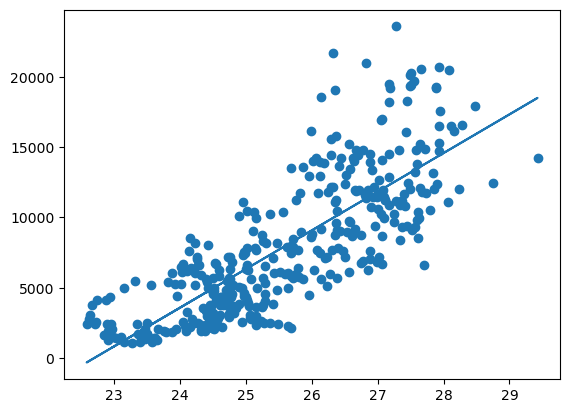

In [44]:
plt.scatter(densdiff_ros2018,rostosouth_2018.dropna()[0:379])
plt.plot(densdiff_ros2018,ddline2018)
slope,intercept

In [83]:
print('----- 2018 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros_2018,ros2south_2018)
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides_2018,res_2018)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2018,res_2018)
print('Winds and Ros:',corr)
corr,p = stats.spearmanr(tides2018_sh,res2018)
print('Tides and Ros (2018):',corr)


print('\n        --- Zone 1 ---')
corr,p = stats.spearmanr(tides_2018[0:idx_z2],res_2018[0:idx_z2])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2018[0:idx_z2],res_2018[0:idx_z2])
print('Winds and Ros:',corr)
print('\n        --- Zone 2 ---')
corr,p = stats.spearmanr(tides_2018[idx_z2:idx_z3],res_2018[idx_z2:idx_z3])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2018[idx_z2:idx_z3],res_2018[idx_z2:idx_z3])
print('Winds and Ros:',corr)
print('\n        --- Zone 3 ---')
corr,p = stats.spearmanr(tides_2018[idx_z3:idx_z4],res_2018[idx_z3:idx_z4])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2018[idx_z3:idx_z4],res_2018[idx_z3:idx_z4])
print('Winds and Ros:',corr)
print('\n        --- Zone 4 ---')
corr,p = stats.spearmanr(tides_2018[idx_z4:],res_2018[idx_z4:])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2018[idx_z4:],res_2018[idx_z4:])
print('Winds and Ros:',corr)


print('\n ----- 2019 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros2019,ros2south_2019.dropna())
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides_2019,res_2019)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2019,res_2019)
print('Winds and Ros:',corr)
corr,p = stats.spearmanr(tides2019_sh,res2019)
print('Tides and Ros:',corr)

print('\n        --- Zone 1 ---')
corr,p = stats.spearmanr(tides_2019[0:idx_z2],res_2019[0:idx_z2])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2019[0:idx_z2],res_2019[0:idx_z2])
print('Winds and Ros:',corr)
print('\n        --- Zone 2 ---')
corr,p = stats.spearmanr(tides_2019[idx_z2:idx_z3],res_2019[idx_z2:idx_z3])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2019[idx_z2:idx_z3],res_2019[idx_z2:idx_z3])
print('Winds and Ros:',corr)
print('\n        --- Zone 3 ---')
corr,p = stats.spearmanr(tides_2019[idx_z3:idx_z4],res_2019[idx_z3:idx_z4])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2019[idx_z3:idx_z4],res_2019[idx_z3:idx_z4])
print('Winds and Ros:',corr)
print('\n        --- Zone 4 ---')
corr,p = stats.spearmanr(tides_2019[idx_z4:],res_2019[idx_z4:])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2019[idx_z4:],res_2019[idx_z4:])
print('Winds and Ros:',corr)

----- 2018 Correlations -----
Densdiff and Ros: 0.8292558573214036
Tides and Ros: -0.05587605777857132
Winds and Ros: -0.23915681904850075
Tides and Ros (2018): -0.009632260069699314

        --- Zone 1 ---
Tides and Ros: -0.14758695309154024
Winds and Ros: -0.009174311926605503

        --- Zone 2 ---
Tides and Ros: -0.04905439217365823
Winds and Ros: 0.0009151770619660528

        --- Zone 3 ---
Tides and Ros: 0.14702297233942804
Winds and Ros: -0.1617205813408345

        --- Zone 4 ---
Tides and Ros: -0.2994888023369036
Winds and Ros: -0.3901898734177216

 ----- 2019 Correlations -----
Densdiff and Ros: 0.6793411735491168
Tides and Ros: -0.10804163719995091
Winds and Ros: -0.20435483965236095
Tides and Ros: -0.07930568062387282

        --- Zone 1 ---
Tides and Ros: 0.0023668372292225503
Winds and Ros: 0.03541239321055835

        --- Zone 2 ---
Tides and Ros: -0.48795167143790996
Winds and Ros: -0.30970403263981244

        --- Zone 3 ---
Tides and Ros: 0.1028129395218003
Winds an

Tides and Ros (2018) is still different than other file ... WHYYYYYYY

In [46]:
len(rostosouth_2018.dropna())

381

Different length by 2 ... Doesn't seem like a large enough difference to matter than much. But maybe its just showing that I've done something differently here.

Or wait exactly 2 ... 29dec vs 31dec here. Try this file with only going to 29dec

In [47]:
len(date_2018)+len(date_2019),len(date_tides_sh)
len(winds_2018)+len(winds_2019),len(winds_sh)

(724, 724)

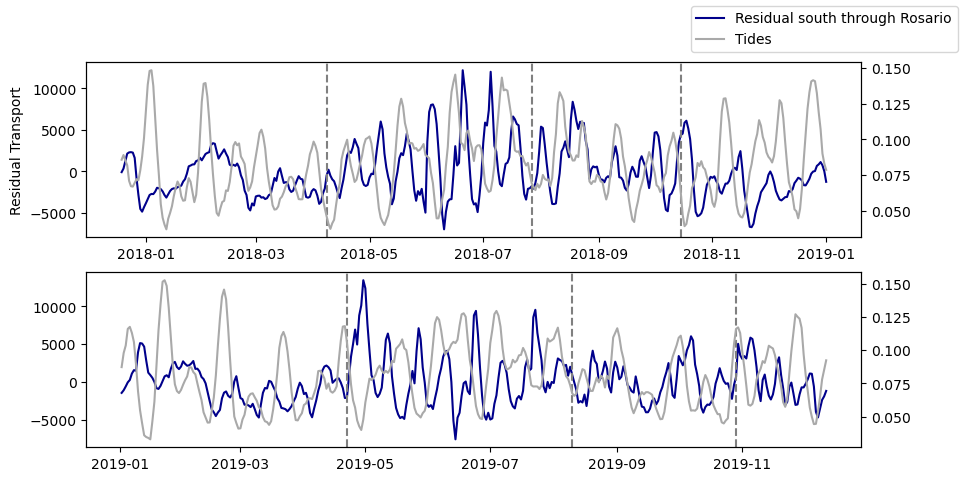

In [48]:
fig,ax = plt.subplots(2,1,figsize=(10,5))
ax2 = ax[0].twinx()
ax2.plot(date_2018,tides_2018,color='darkgrey',label='Tides')
ax[0].set_ylabel('Residual Transport')
# ax.plot(rostosouth.dropna(),label='Transport south through Rosario')
ax[0].plot(res_2018,label='Residual south through Rosario',color='darkblue')
ax[0].axvline(date_tides_sh[110],ls='--',color='grey')
ax[0].axvline(date_tides_sh[220],ls='--',color='grey')
ax[0].axvline(date_tides_sh[300],ls='--',color='grey')
ax3 = ax[1].twinx()
ax3.plot(date_2019,tides_2019,color='darkgrey')
ax[1].plot(res_2019,color='darkblue')
ax[1].axvline(date_2019[110],ls='--',color='grey')
ax[1].axvline(date_2019[220],ls='--',color='grey')
ax[1].axvline(date_2019[300],ls='--',color='grey')
fig.legend()

Plot is starting at 19dec because of shift, not 10dec

2019 almost has more distinct 4 regions ... Look at correlation to see if this is in fact the case. Would almost move 2nd line even more right?

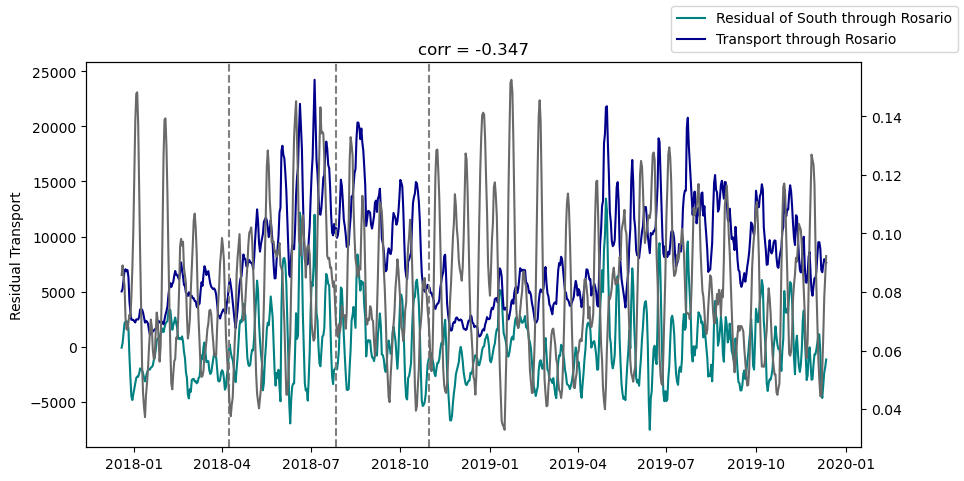

In [49]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='dimgrey')
ax.plot(rostosouth.dropna(),color='darkblue',label='Transport through Rosario')
# ax.plot(harotosouth.dropna(),color='sienna',label='Transport through Haro')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[315],ls='--',color='grey')

Look at correlation in zone 2 of tides with residual Rosario transport. Zone 2 looks like its better (inversely) correlated with the tides than the others

In [50]:
# mask = np.isin(datelist_winds,date_harosh)
# date_winds_sh = np.array(datelist_winds)[mask]
# winds_haro = y_mean4[mask]

# corr,p = stats.spearmanr(winds_haro,res_haro)
# corr

# fig,ax = plt.subplots(figsize=(10,5))
# ax.plot(res_haro,color='teal',label='Residual of South through Rosario')
# ax2 = ax.twinx()
# ax2.plot(date_winds_sh,winds_haro,color='k',label='Winds')
# fig.legend()
# ax.set_ylabel('Residual Transport')
# ax.set_title(f'corr = {np.round(corr,3)}')
# ax2.set_ylabel('Wind velocity')

#### Split into sub regions to check correlation

In [51]:
aa = date_tides_haro_sh[20:100]
aaa = date_tides_sh[20:100]
a = res_haro[20:100]
b = tides_haro_sh[20:100]
c = winds_haro[20:100]
d = rostosouth.dropna()[20:100]
e = res[20:100]
f = res_ros2[20:100]
bb = tides_sh[20:100]

corr1,p = stats.spearmanr(a,b)
print(corr1)

corr2,p = stats.spearmanr(a,c)
print(corr2)

corr3,p = stats.spearmanr(bb,d)
print(corr3)

corr4,p = stats.spearmanr(b,e)
print('Correlation with res ros and tides:',corr4)

corr5,p = stats.spearmanr(b,f)
print(corr5)

corr6,p = stats.spearmanr(tides_sh,res)
print(corr6)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport (m3/s)')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='lightgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 60))
ax4 = ax.twinx()
ax4.plot(aa,d,color='darkblue',label='Transport')
ax4.spines['right'].set_position(('outward', 120))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()
ax.set_title(f'Correlation: {np.round(corr1,3)}')

NameError: name 'date_tides_haro_sh' is not defined

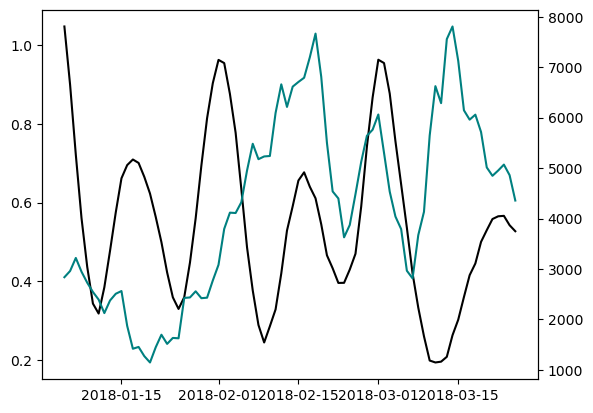

In [ ]:
fig,ax = plt.subplots()

ax.plot(aaa,bb,color='k')
ax2 = ax.twinx()
ax2.plot(d,color='teal')

Look at the correlation with density difference b/w VicSill and PR (vs. N/S of Rosario)

**High correlation of transport to the wind (likely because the wind and density difference are highly correlated) - residual high correlation with the tides and very low with the winds

0.42195072470301825
-0.2575073822780245
-0.031724635394360164
0.17205779591100692
-0.05127245677704393


Text(0.5, 1.0, 'Zone 2: Correlation: 0.422')

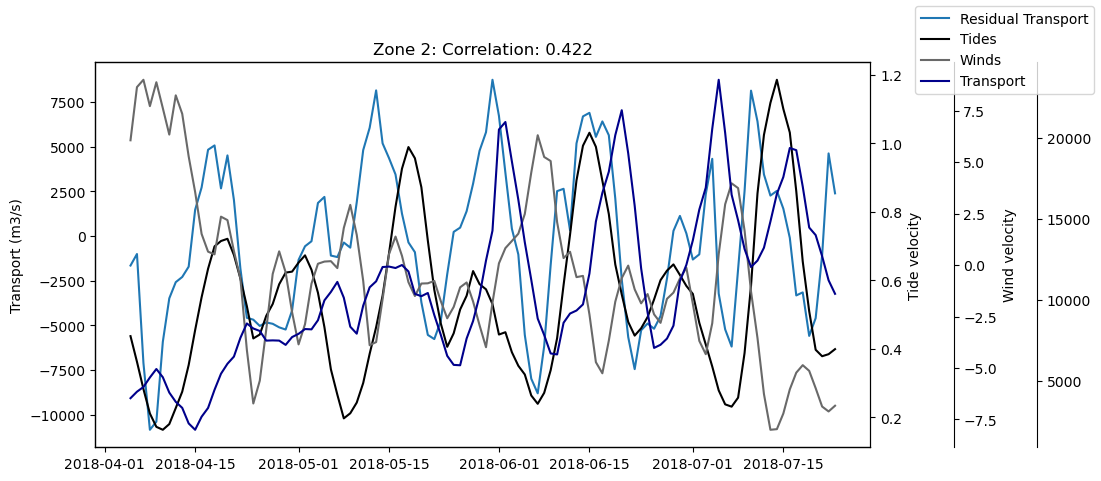

In [ ]:
aa = date_tides_sh[110:220]
a = res_haro[113:223]
b = tides_sh[110:220]
c = winds_sh[110:220]
d = rostosouth.dropna()[110:220]
e = res[110:220]
f = res_ros2[110:220]

corr1,p = stats.spearmanr(a,b)
print(corr1)
corr2,p = stats.spearmanr(a,c)
print(corr2)
corr3,p = stats.spearmanr(b,e)
print(corr3)
corr4,p = stats.spearmanr(b,d)
print(corr4)
corr5,p = stats.spearmanr(b,f)
print(corr5)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='dimgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 60))
ax4 = ax.twinx()
ax4.plot(aa,d,color='darkblue',label='Transport')
ax4.spines['right'].set_position(('outward', 120))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()
ax.set_title(f'Zone 2: Correlation: {np.round(corr1,3)}')

Correlation with residual rosTsouth is high... but positive. Even higher than through Haro.

If we look at density difference from Rosario to PR its higher ... So stick with this
(try from PR to VS?) - How to tell which density difference I'm even looking at ?? IDK that's my fault

-0.25662684078910813
0.026229508196721315
0.05907196443456518
-0.13303695470964158


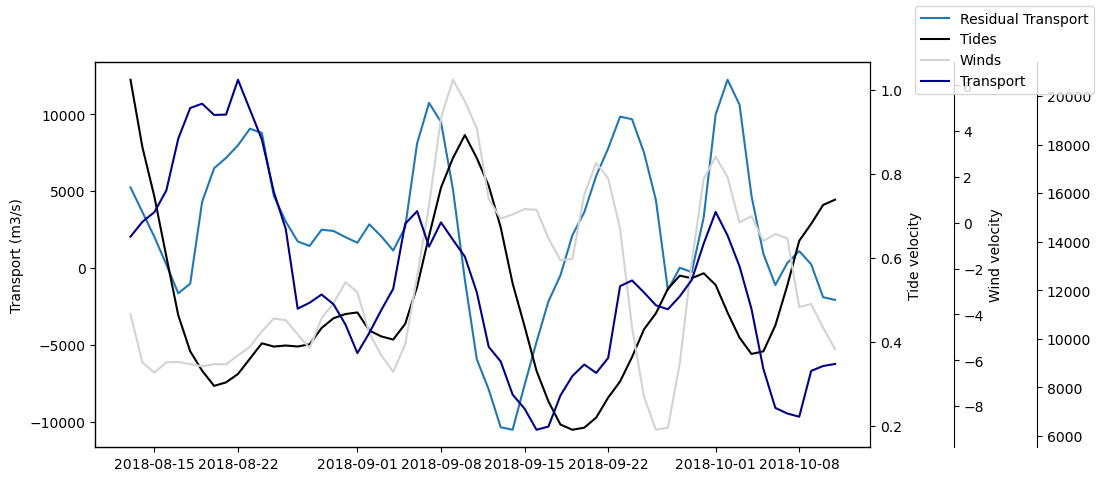

In [ ]:
aa = date_tides_sh[240:300]
a = res_haro[240:300]
b = tides_sh[240:300]
c = winds_sh[240:300]
d = rostosouth.dropna()[240:300]
e = res[240:300]

corr1,p = stats.spearmanr(a,b)
print(corr1)
corr2,p = stats.spearmanr(a,c)
print(corr2)
corr3,p = stats.spearmanr(b,d)
print(corr3)
corr4,p = stats.spearmanr(b,e)
print(corr4)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='lightgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 60))
ax4 = ax.twinx()
ax4.plot(aa,d,color='darkblue',label='Transport')
ax4.spines['right'].set_position(('outward', 120))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()

0.16628529698149952
-0.5323028237585199
-0.3643378773125609
-0.29790652385589095
-0.4677458617332035


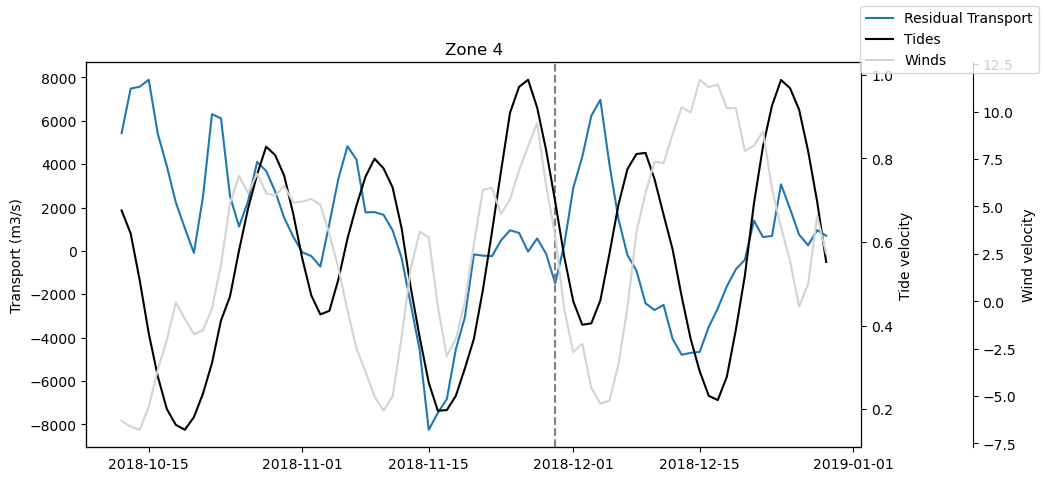

In [ ]:
aa = date_tides_sh[300:]
a = res_haro[303:]
b = tides_sh[300:]
c = winds_haro[303:]
d = rostosouth.dropna()[300:]
e = res[300:]

corr1,p = stats.spearmanr(a,b)
print(corr1)
corr2,p = stats.spearmanr(a,c)
print(corr2)
corr3,p = stats.spearmanr(b,d)
print(corr3)
corr4,p = stats.spearmanr(b,e)
print(corr4)
corr5,p = stats.spearmanr(c,d)
print(corr5)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='lightgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 80))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()
ax.set_title('Zone 4')
ax.axvline(date_tides_sh[348],ls='--',color='grey')

#### Additional Zone 4 Analysis

Try these 2 ^^ subregions

0.16825879287885367
-0.3054711246200608
-0.5140034737299175
-0.4077290490664351
-0.556665219279201


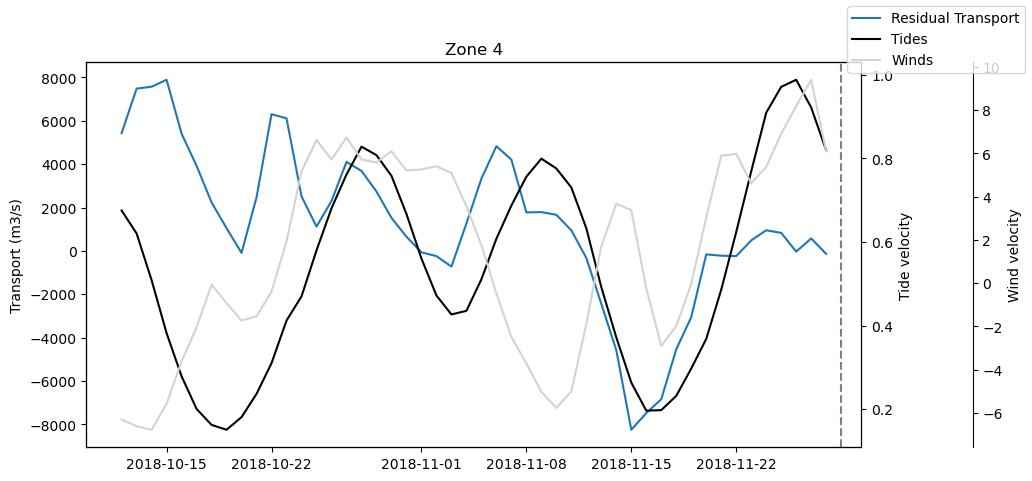

In [ ]:
aa = date_tides_sh[300:348]
a = res_haro[303:351]
b = tides_sh[300:348]
c = winds_haro[303:351]
d = rostosouth.dropna()[300:348]
e = res[300:348]

corr1,p = stats.spearmanr(a,b)
print(corr1)
corr2,p = stats.spearmanr(a,c)
print(corr2)
corr3,p = stats.spearmanr(b,d)
print(corr3)
corr4,p = stats.spearmanr(b,e)
print(corr4)
corr5,p = stats.spearmanr(c,d)
print(corr5)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='lightgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 80))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()
ax.set_title('Zone 4')
ax.axvline(date_tides_sh[348],ls='--',color='grey')

This increased negative correlation with winds -> Calculate residual of rosario and haro after winds

In [ ]:
slope,intercept = np.polyfit(winds_haro[303:351],res_haro[303:351],1)
wind_line_haro = slope*winds_haro[303:351]+intercept
res_haro_wind = res_haro[303:351].values - wind_line_haro

corr,p = stats.spearmanr(tides_haro_sh[303:351],res_haro_wind)
print(corr)

slope,intercept = np.polyfit(winds_sh[300:348],res[300:348],1)
wind_line_ros = slope*winds_sh[300:348]+intercept
res_ros_wind = res[300:348].values - wind_line_ros

corr,p = stats.spearmanr(tides_sh[300:348],res_ros_wind)
print(corr)

0.26194094659140255
-0.25


Text(0, 0.5, 'Tide velocity ')

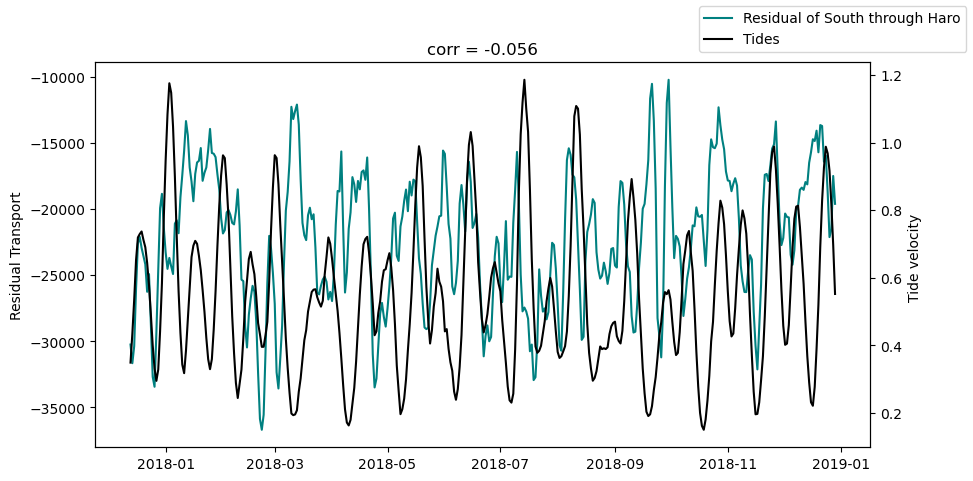

In [ ]:
slope,intercept = np.polyfit(winds_haro,harotosouth.dropna(),1)
wline_haro = slope*winds_haro+intercept
resw_haro = res_haro.values - wline_haro

mask = np.isin(datelist_tides,date_winds_sh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_sh = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_sh,resw_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(date_tides_sh,resw_haro,color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax2.set_ylabel('Tide velocity ')

#### Transport south through Rosario